# ChebGCNs 


Spectral Graph ConvNets<br>
Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering<br>
M Defferrard, X Bresson, P Vandergheynst<br>

DOC : https://docs.dgl.ai/en/latest/api/python/nn.pytorch.html?highlight=cheb#dgl.nn.pytorch.conv.ChebConv

In [1]:
import os
import sys
import time
import numpy as np

# -------------Torch-------------------
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# -------------Graph-------------------
import dgl
import networkx as nx
import matplotlib.pyplot as plt


sys.path.insert(0, "../lib/")
from utils import set_device
from laplacian import normalized_laplacian

%load_ext autoreload
%autoreload 2

In [2]:
# GPU Compatibility
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

device = set_device(verbose=True)

cuda available


# MNIST

In [3]:
# Downloads the dataset if not found locally
from mnist import check_mnist_dataset_exists, datasampler, MNISTDataset, MNIST_rand

_ = check_mnist_dataset_exists()

nb_selected_train_data = 55000
nb_selected_test_data = 10000

train_data, train_labels, test_data, test_labels, val_data, val_labels= datasampler(
    nb_selected_train_data, nb_selected_test_data
)

trainset = MNIST_rand(train_data, train_labels, removal_rate=0.25)
valset = MNISTDataset(val_data, val_labels)
testset = MNIST_rand(test_data, test_labels)

## Convolution layer and classifier


In [4]:
from model import SmallCheb

In [5]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label, signal).
    graphs, labels, signals = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels),  torch.stack(signals).view(-1)

# Debug section
Verifying all of the steps

In [7]:
g, l, s = trainset[0]

# model_parameters
in_features = 1
first_conv_out = 32
second_conv_out = 50
hidden_layer_classifier = 512
k = 5
n_classes = trainset.num_classes

net2 = SmallCheb(
    in_features, first_conv_out, hidden_layer_classifier, n_classes, k
).to(device)
print("-------------------- Network model --------------------\n", net2)

t = time.time()
# Calculate L
g.to(device)
#L = normalized_laplacian(g).to(device)
#print("L", L, "size:", len(L), "time", time.time() - t,'\n')
#plt.spy(L.cpu().to_dense())

-------------------- Network model --------------------
 SmallCheb(
  (layers): ModuleList(
    (0): Cheb_Conv(
      (fc): Linear(in_features=5, out_features=32, bias=True)
    )
  )
  (classify): Sequential(
    (0): Linear(in_features=25088, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)


DGLGraph(num_nodes=784, num_edges=2634,
         ndata_schemes={}
         edata_schemes={})

In [11]:
print("\n --------------------  Output for graph g:  --------------------\n", net2(g, s, L))

torch.Size([784, 1])


RuntimeError: Could not run 'aten::reciprocal.out' with arguments from the 'SparseCUDATensorId' backend. 'aten::reciprocal.out' is only available for these backends: [CUDATensorId, CPUTensorId, VariableTensorId].



# Model definition for training

In [13]:
# model_parameters
in_features = 1
first_conv_out = 32
#second_conv_out = 50
hidden_layer_classifier = 512
k = 10
n_classes = trainset.num_classes

net = SmallCheb(
    in_features, first_conv_out, hidden_layer_classifier, n_classes, k
)

print(net)
if torch.cuda.is_available():
    net.to(device)

TypeError: super(type, obj): obj must be an instance or subtype of type

# Training pipe

In [9]:
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=1024,
                         shuffle=True, collate_fn=collate)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

epoch_losses = []

## Training time

In [12]:
from laplacian import normalized_laplacian
net.train()
optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in range(1):
    epoch_loss = 0
    t0 = time.time()
    for iter, (bg, label, signal) in enumerate(data_loader):
        if iter == 0:
            L = normalized_laplacian(bg).to(device)
            #t = time.time()
            #print('\n THIS /!\ \n')
            #plt.imshow(signal.view(-1, 28), cmap='gray_r')

        if torch.cuda.is_available():
            bg.to(device)

        prediction = net(bg, signal, L)

        if iter == 0:
            #print("prediction time:", time.time() - t)
            t = time.time()
            print("One Prediction:\n", prediction[0], 'len:',
                  prediction.size(), '\n label:', label[0])  # DEBUG
        loss = loss_func(prediction, label.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.detach().item()

    epoch_loss /= iter + 1
    print(
        "Epoch {}, loss {:.4f}, in {:.2f}(s) ".format(
            epoch, epoch_loss, time.time() - t0
        )
    )
    epoch_losses.append(epoch_loss)

One Prediction:
 tensor([ 38.7243, -10.2882,   4.7362,  -7.5051,  -2.1579,   1.0715,   8.5105,
         -9.6576,   3.4601,   8.9891], device='cuda:0',
       grad_fn=<SelectBackward>) len: torch.Size([1024, 10]) 
 label: tensor(0)
Epoch 0, loss 0.0045, in 61.77(s) 


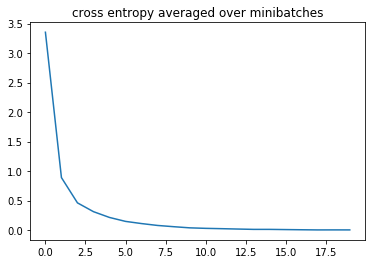

In [13]:
plt.title("cross entropy averaged over minibatches")
plt.plot(epoch_losses)
plt.show()

In [14]:
torch.cuda.empty_cache()

## Test Metrics

In [15]:
# Change

net.eval()
# Convert a list of tuples to two lists
test_X, test_Y, test_S = map(list, zip(*testset))
test_bg = dgl.batch(test_X)
test_Y = torch.tensor(test_Y).float().view(-1, 1)
L = normalized_laplacian(test_bg)
test_S = torch.stack(test_S).view(-1)
probs_Y = torch.softmax(net(test_bg.to(device),test_S.to(device), L.to(device)), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print(
    "Accuracy of sampled predictions on the test set: {:.4f}%".format(
        (test_Y == sampled_Y.cpu().float()).sum().item() / len(test_Y) * 100
    )
)
print(
    "Accuracy of argmax predictions on the test set: {:4f}%".format(
        (test_Y == argmax_Y.cpu().float()).sum().item() / len(test_Y) * 100
    )
)

Accuracy of sampled predictions on the test set: 95.8008%
Accuracy of argmax predictions on the test set: 95.605469%


In [16]:
# BATCHED DGL EXAMPLE
import sklearn
from sklearn.metrics import classification_report

print(sklearn.metrics.classification_report(test_Y.cpu(), argmax_Y.cpu()))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96        87
         1.0       0.99      0.98      0.98       130
         2.0       0.96      0.94      0.95       118
         3.0       0.97      0.96      0.97       108
         4.0       0.96      0.96      0.96       113
         5.0       0.98      0.94      0.96        89
         6.0       0.97      0.93      0.95        89
         7.0       0.96      0.95      0.96       102
         8.0       0.88      0.95      0.91        91
         9.0       0.95      0.96      0.95        97

    accuracy                           0.96      1024
   macro avg       0.95      0.96      0.95      1024
weighted avg       0.96      0.96      0.96      1024



## Saving

In [17]:
from utils import save_model

save_model("Model_6000_20ep", net)